## Import Package

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score, roc_auc_score,
    confusion_matrix, classification_report
)
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

### Load RVI Data

In [2]:
df_rvi = pd.read_csv('input/data_compile_agro_sentinel_1_rvi.csv')

In [3]:
df_vh = pd.read_csv('../Data untuk modelling/data_compile_agro_sentinel_1.csv')

In [4]:
df_rvi = df_rvi[['idsubsegmen_repair','RVI_61', 'RVI_60', 'RVI_59', 'RVI_58',
       'RVI_57', 'RVI_56', 'RVI_55', 'RVI_54', 'RVI_53', 'RVI_52', 'RVI_51',
       'RVI_50', 'RVI_49', 'RVI_48', 'RVI_47', 'RVI_46', 'RVI_45', 'RVI_44',
       'RVI_43', 'RVI_42', 'RVI_41', 'RVI_40', 'RVI_39', 'RVI_38', 'RVI_37',
       'RVI_36', 'RVI_35', 'RVI_34', 'RVI_33', 'RVI_32', 'RVI_31', 'RVI_30',
       'RVI_29', 'RVI_28', 'RVI_27', 'RVI_26', 'RVI_25', 'RVI_24', 'RVI_23',
       'RVI_22', 'RVI_21', 'RVI_20', 'RVI_19', 'RVI_18', 'RVI_17', 'RVI_16',
       'RVI_15', 'RVI_14', 'RVI_13', 'RVI_12', 'RVI_11', 'RVI_10', 'RVI_9',
       'RVI_8', 'RVI_7', 'RVI_6', 'RVI_5', 'RVI_4', 'RVI_3', 'RVI_2', 'RVI_1',
       'RVI_0']]

In [5]:
df = pd.merge(df_vh, df_rvi, on='idsubsegmen_repair', how='inner')

In [6]:
df = df.iloc[:,1:]

In [7]:
df = df.loc[df.obs != 12]

### Define Function Training

In [30]:
def training(X, y, scenario_name): 
    # Split data into train-test (70%-30%)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=1234
    )
    
    scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)  # Majority/Minority class ratio
    
    # Stratified 3-Fold Cross Validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)
    metrics = []
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx, :], X_train.iloc[val_idx, :]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
        # Train XGBoost model
        model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=1234,
                                  scale_pos_weight=scale_pos_weight)
        model.fit(X_train_fold, y_train_fold)
    
        # Predict on validation data
        y_pred = model.predict(X_val_fold)
        y_prob = model.predict_proba(X_val_fold)[:, 1]  # Probabilities for positive class
    
        # Calculate metrics
        precision = precision_score(y_val_fold, y_pred, average=None, zero_division=0)
        recall = recall_score(y_val_fold, y_pred, average=None, zero_division=0)
        accuracy = accuracy_score(y_val_fold, y_pred)
        f1_macro = f1_score(y_val_fold, y_pred, average="macro")
        auc = roc_auc_score(y_val_fold, y_prob)
    
        metrics.append({
            "precision_per_class": precision,
            "recall_per_class": recall,
            "accuracy": accuracy,
            "f1_macro": f1_macro,
            "auc": auc
        })

    # Compute average metrics across folds
    avg_precision = np.mean([m["precision_per_class"] for m in metrics], axis=0)
    avg_recall = np.mean([m["recall_per_class"] for m in metrics], axis=0)
    avg_accuracy = np.mean([m["accuracy"] for m in metrics])
    avg_f1_macro = np.mean([m["f1_macro"] for m in metrics])
    avg_auc = np.mean([m["auc"] for m in metrics])
    
    print(f"Average Metrics across Folds ({scenario_name}):")
    print("Precision per class:", avg_precision)
    print("Recall per class:", avg_recall)
    print("Accuracy:", avg_accuracy)
    print("F1-Macro:", avg_f1_macro)
    print("AUC ROC:", avg_auc)
    
    # Train final model on the full training set
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for positive class
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix ({scenario_name})")
    plt.show()

    # Feature importance
    feature_importances = model.feature_importances_
    importance_df = pd.DataFrame({
        "Feature": X.columns,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False).head(8)
    print(f"\n Top 8 Features ({scenario_name}):\n", importance_df)

    # Final Metrics
    precision_test = precision_score(y_test, y_test_pred, average=None, zero_division=0)
    recall_test = recall_score(y_test, y_test_pred, average=None, zero_division=0)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    f1_macro_test = f1_score(y_test, y_test_pred, average="macro")
    auc_test = roc_auc_score(y_test, y_test_prob)
    
    print(f"\nPrecision per class (Test) ({scenario_name}):", precision_test)
    print(f"Recall per class (Test) ({scenario_name}):", recall_test)
    print(f"Accuracy (Test) ({scenario_name}):", accuracy_test)
    print(f"F1-Macro (Test) ({scenario_name}):", f1_macro_test)
    print(f"AUC ROC (Test) ({scenario_name}):", auc_test)
    
    # Classification Report
    print(f"\nClassification Report (Test) ({scenario_name}):")
    print(classification_report(y_test, y_test_pred, target_names=["Class 0", "Class 1"]))
    
    # Return metrics for the current scenario
    return {
        "scenario": scenario_name,
        "precision_class_0": avg_precision[0],
        "precision_class_1": avg_precision[1],
        "recall_class_0": avg_recall[0],
        "recall_class_1": avg_recall[1],
        "accuracy": avg_accuracy,
        "f1_macro": avg_f1_macro,
        "auc": avg_auc,
        "precision_test_class_0": precision_test[0],
        "precision_test_class_1": precision_test[1],
        "recall_test_class_0": recall_test[0],
        "recall_test_class_1": recall_test[1],
        "accuracy_test": accuracy_test,
        "f1_macro_test": f1_macro_test,
        "auc_test": auc_test,
        "top_5_features": importance_df
    }, model

In [51]:
def test(model, X_test, y_test):
    from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
    # Train final model on the full training set
    y_test_pred = model.predict(X_test)
    # Final Metrics
    precision_test = precision_score(y_test, y_test_pred, average=None, zero_division=0)
    recall_test = recall_score(y_test, y_test_pred, average=None, zero_division=0)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    f1_macro_test = f1_score(y_test, y_test_pred, average="macro")
    print(f"\nPrecision per class (Test) :", precision_test)
    print(f"Recall per class (Test) :", recall_test)
    print(f"Accuracy (Test) :", accuracy_test)
    print(f"F1-Macro (Test) :", f1_macro_test)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

### Modelling RVI dan VH for 24 Months

In [9]:
X = df.iloc[:,-124:]
y = df["is_puso"]

Average Metrics across Folds (24 Bulan):
Precision per class: [0.92131327 0.74956306]
Recall per class: [0.98047176 0.40992908]
Accuracy: 0.9095561729794058
F1-Macro: 0.7397144124197922
AUC ROC: 0.8315522784789032


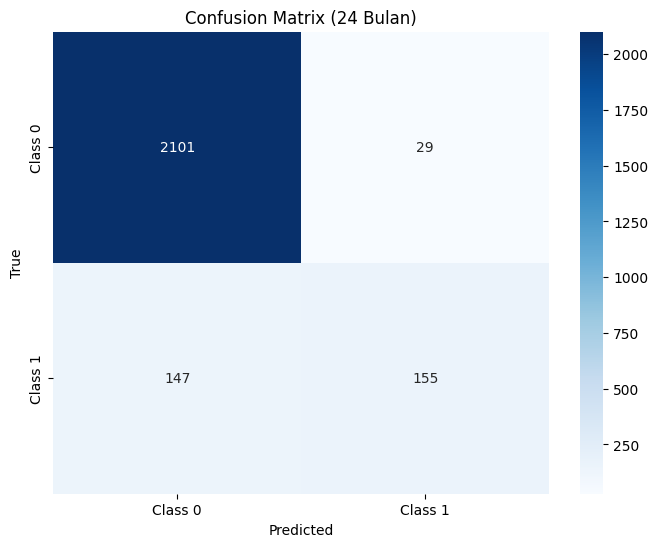


 Top 8 Features (24 Bulan):
     Feature  Importance
39    VH_22    0.019897
9     VH_52    0.019523
123   RVI_0    0.018881
3     VH_58    0.018355
30    VH_31    0.017264
51    VH_10    0.016628
40    VH_21    0.016399
57     VH_4    0.016044

Precision per class (Test) (24 Bulan): [0.93460854 0.8423913 ]
Recall per class (Test) (24 Bulan): [0.98638498 0.51324503]
Accuracy (Test) (24 Bulan): 0.9276315789473685
F1-Macro (Test) (24 Bulan): 0.7988295386397006
AUC ROC (Test) (24 Bulan): 0.8771787457637659

Classification Report (Test) (24 Bulan):
              precision    recall  f1-score   support

     Class 0       0.93      0.99      0.96      2130
     Class 1       0.84      0.51      0.64       302

    accuracy                           0.93      2432
   macro avg       0.89      0.75      0.80      2432
weighted avg       0.92      0.93      0.92      2432



In [10]:
metrics_24bulan = training(X, y, "24 Bulan")

In [11]:
metrics_24bulan

{'scenario': '24 Bulan',
 'precision_class_0': 0.9213132708379446,
 'precision_class_1': 0.7495630589371816,
 'recall_class_0': 0.9804717564010877,
 'recall_class_1': 0.4099290780141844,
 'accuracy': 0.9095561729794058,
 'f1_macro': 0.7397144124197922,
 'auc': 0.8315522784789032,
 'precision_test_class_0': 0.9346085409252669,
 'precision_test_class_1': 0.842391304347826,
 'recall_test_class_0': 0.9863849765258216,
 'recall_test_class_1': 0.5132450331125827,
 'accuracy_test': 0.9276315789473685,
 'f1_macro_test': 0.7988295386397006,
 'auc_test': 0.8771787457637659,
 'top_5_features':     Feature  Importance
 39    VH_22    0.019897
 9     VH_52    0.019523
 123   RVI_0    0.018881
 3     VH_58    0.018355
 30    VH_31    0.017264
 51    VH_10    0.016628
 40    VH_21    0.016399
 57     VH_4    0.016044}

# Prediksi Lag

### Lag 1 Bulan

#### Data Training 2022-01 - 2023-11

In [69]:
df_lt_2023_11 = df.loc[(df['tahun'] != 23) & (df['bulan'] <= 11)]

In [70]:
df_lt_2023_11.shape

(3611, 136)

In [71]:
X = df_lt_2023_11.iloc[:,-124:]
y = df_lt_2023_11["is_puso"]

Average Metrics across Folds (2022-01 - 2023-11):
Precision per class: [0.93200168 0.73450292]
Recall per class: [0.99133692 0.23744292]
Accuracy: 0.9259990288426226
F1-Macro: 0.6576243349355154
AUC ROC: 0.7337507876332537


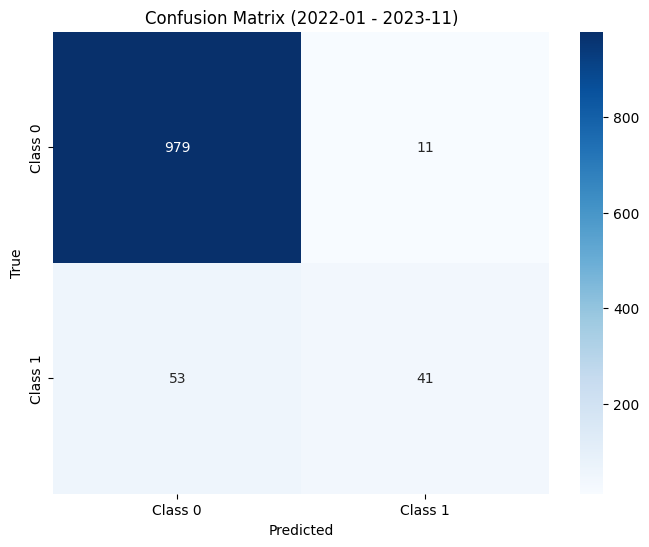


 Top 8 Features (2022-01 - 2023-11):
     Feature  Importance
27    VH_34    0.025749
2     VH_59    0.024142
40    VH_21    0.023843
112  RVI_11    0.020816
65   RVI_58    0.019294
7     VH_54    0.018684
13    VH_48    0.018256
88   RVI_35    0.017791

Precision per class (Test) (2022-01 - 2023-11): [0.94864341 0.78846154]
Recall per class (Test) (2022-01 - 2023-11): [0.98888889 0.43617021]
Accuracy (Test) (2022-01 - 2023-11): 0.940959409594096
F1-Macro (Test) (2022-01 - 2023-11): 0.764996002872512
AUC ROC (Test) (2022-01 - 2023-11): 0.8717171717171716

Classification Report (Test) (2022-01 - 2023-11):
              precision    recall  f1-score   support

     Class 0       0.95      0.99      0.97       990
     Class 1       0.79      0.44      0.56        94

    accuracy                           0.94      1084
   macro avg       0.87      0.71      0.76      1084
weighted avg       0.93      0.94      0.93      1084



In [72]:
metrics_23bulan, model = training(X, y, "2022-01 - 2023-11")

#### Predict Data 2023-12

In [82]:
df_2023_12 = df.loc[(df['tahun'] == 23) & (df['bulan'] == 12)]

In [83]:
X_test = df_2023_12.iloc[:,-124:]
y_test = df_2023_12['is_puso']


Precision per class (Test) : [0.93728223 0.        ]
Recall per class (Test) : [0.96071429 0.        ]
Accuracy (Test) : 0.9026845637583892
F1-Macro (Test) : 0.47442680776014107


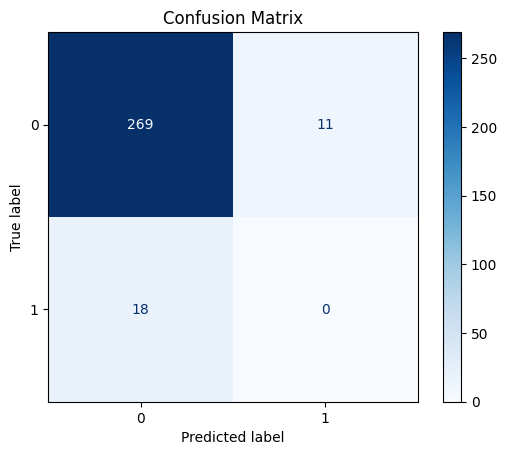

In [84]:
test(model, X_test, y_test)

### Lag 3 Bulan
#### Data Training 2022-01 - 2023-09

In [85]:
df_lt_2023_09 = df.loc[(df['tahun'] != 23) & (df['bulan'] <= 9)]

In [86]:
X = df_lt_2023_06.iloc[:,-124:]
y = df_lt_2023_06["is_puso"]

Average Metrics across Folds (2022-01 - 2023-09):
Precision per class: [0.92664526 0.77307234]
Recall per class: [0.9880268  0.34217687]
Accuracy: 0.9193982320320652
F1-Macro: 0.7153253277341428
AUC ROC: 0.7691456029590934


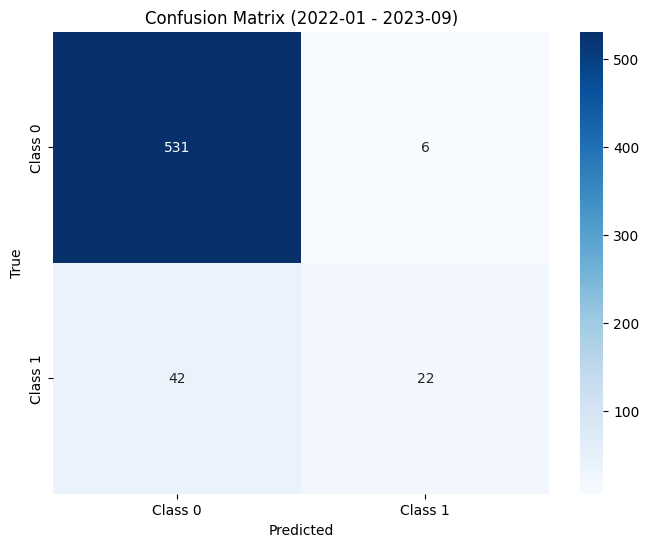


 Top 8 Features (2022-01 - 2023-09):
     Feature  Importance
51    VH_10    0.027648
29    VH_32    0.024106
15    VH_46    0.023879
32    VH_29    0.023003
55     VH_6    0.022670
45    VH_16    0.021977
112  RVI_11    0.021668
72   RVI_51    0.019075

Precision per class (Test) (2022-01 - 2023-09): [0.92670157 0.78571429]
Recall per class (Test) (2022-01 - 2023-09): [0.98882682 0.34375   ]
Accuracy (Test) (2022-01 - 2023-09): 0.9201331114808652
F1-Macro (Test) (2022-01 - 2023-09): 0.717508813160987
AUC ROC (Test) (2022-01 - 2023-09): 0.8479108472998138

Classification Report (Test) (2022-01 - 2023-09):
              precision    recall  f1-score   support

     Class 0       0.93      0.99      0.96       537
     Class 1       0.79      0.34      0.48        64

    accuracy                           0.92       601
   macro avg       0.86      0.67      0.72       601
weighted avg       0.91      0.92      0.91       601



In [87]:
metrics_21bulan, model = training(X, y, "2022-01 - 2023-09")

#### Prediction 2023-12

In [88]:
df_2023_12 = df.loc[(df['tahun'] == 23) & (df['bulan'] == 12)]

In [89]:
X_test = df_2023_12.iloc[:,-124:]
y_test = df_2023_12['is_puso']


Precision per class (Test) : [0.93661972 0.        ]
Recall per class (Test) : [0.95 0.  ]
Accuracy (Test) : 0.8926174496644296
F1-Macro (Test) : 0.4716312056737589


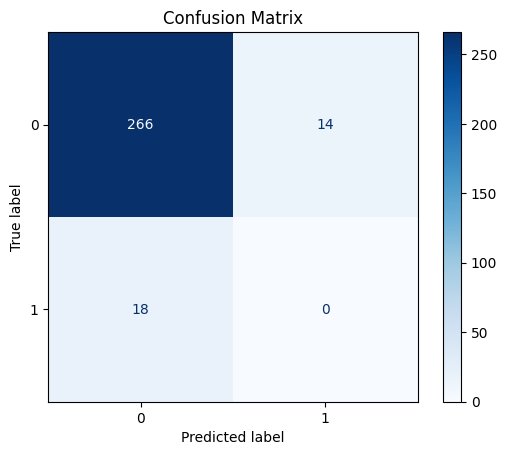

In [90]:
test(model, X_test, y_test)

### Lag 6 Bulan
#### Data Training 2022-01 - 2023-06

In [73]:
df_lt_2023_06 = df.loc[(df['tahun'] != 23) & (df['bulan'] <= 6)]

In [74]:
df_lt_2023_06.shape

(2003, 136)

In [28]:
X = df_lt_2023_06.iloc[:,-124:]
y = df_lt_2023_06["is_puso"]

Average Metrics across Folds (2022-01 - 2023-06):
Precision per class: [0.92360856 0.67936508]
Recall per class: [0.9808978  0.32055749]
Accuracy: 0.9104137976260738
F1-Macro: 0.6913999357540371
AUC ROC: 0.7505183218021293


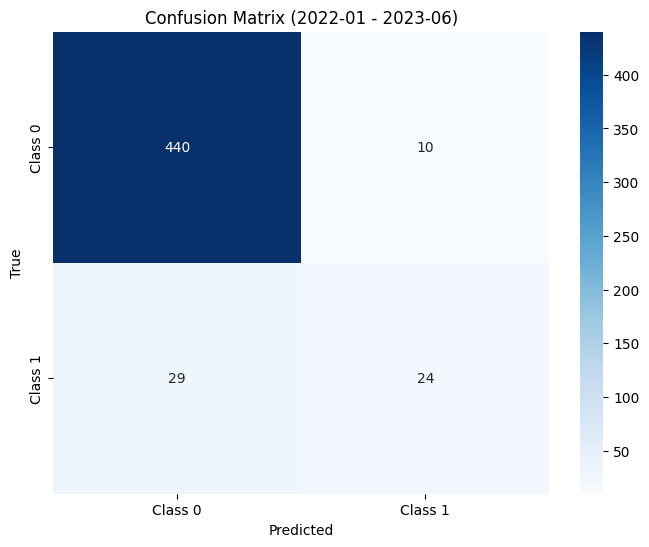


 Top 8 Features (2022-01 - 2023-06):
    Feature  Importance
65  RVI_58    0.057991
20   VH_41    0.024172
30   VH_31    0.021342
25   VH_36    0.021286
77  RVI_46    0.020367
67  RVI_56    0.019618
57    VH_4    0.019273
22   VH_39    0.019168

Precision per class (Test) (2022-01 - 2023-06): [0.93816631 0.70588235]
Recall per class (Test) (2022-01 - 2023-06): [0.97777778 0.45283019]
Accuracy (Test) (2022-01 - 2023-06): 0.9224652087475149
F1-Macro (Test) (2022-01 - 2023-06): 0.7546433529698697
AUC ROC (Test) (2022-01 - 2023-06): 0.8116142557651992

Classification Report (Test) (2022-01 - 2023-06):
              precision    recall  f1-score   support

     Class 0       0.94      0.98      0.96       450
     Class 1       0.71      0.45      0.55        53

    accuracy                           0.92       503
   macro avg       0.82      0.72      0.75       503
weighted avg       0.91      0.92      0.91       503



In [31]:
metrics_18bulan, model = training(X, y, "2022-01 - 2023-06")

#### Predict Data 2023-12

In [61]:
df_2023_12 = df.loc[(df['tahun'] == 23) & (df['bulan'] == 12)]

In [62]:
X_test = df_2023_12.iloc[:,-124:]
y_test = df_2023_12['is_puso']


Precision per class (Test) : [0.94699647 0.2       ]
Recall per class (Test) : [0.95714286 0.16666667]
Accuracy (Test) : 0.9093959731543624
F1-Macro (Test) : 0.5669304052963022


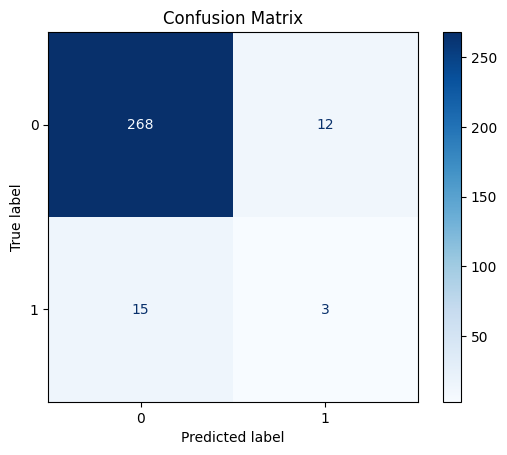

In [63]:
test(model, X_test, y_test)

#### Predict Data 2023-07

In [33]:
df_2023_07 = df.loc[(df['tahun'] == 23) & (df['bulan'] == 7)]

In [53]:
X_test = df_2023_07.iloc[:,-124:]
y_test = df_2023_07['is_puso']


Precision per class (Test) : [0.75628141 0.        ]
Recall per class (Test) : [0.95859873 0.        ]
Accuracy (Test) : 0.732360097323601
F1-Macro (Test) : 0.42275280898876405


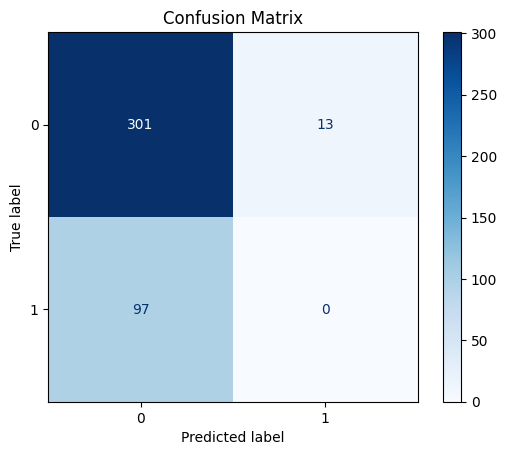

In [52]:
test(model, X_test, y_test)